# RK Net

In [1]:
import torch
import torch.nn as nn
import numpy as np
import sklearn
from torch import Tensor
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics.classification import BinaryPrecisionRecallCurve
from torchmetrics.classification import BinaryAccuracy
from tqdm.auto import tqdm
from sklearn.metrics import auc
from sklearn.datasets import make_circles

In [26]:
def train_model(
    model,
    data_loader,
    loss_fn,
    optimizer,
    verbose=False,
):
    """
    Training loop for 1 epoch

    Args:
        model (_type_): _description_
        data_loader (_type_): _description_
        loss_fn (_type_): _description_
        optimizer (_type_): _description_
    """
    train_loss = 0.0 # keep track of total loss
    train_acc = 0.0 # keep track of the total accuracy
    
    for batch, (X_data, y_data) in enumerate(data_loader):
        model.train() # Set to training mode
        
        # Forward pass - make a prediction
        y_prob = model(X_data) # (model outputs probabilities)
        y_pred = torch.round(y_prob) # (probabilities -> binary prediction)
        # note: perform sigmoid on the "logits" dimension, not "batch" dimension 
        # (in this case we have a batch size of 1, so can perform on dim=0)
        
        # Compute the loss
        loss = loss_fn(y_prob, y_data)
        train_loss += loss
        if y_pred.shape == y_data.shape:
            acc = torch.eq(y_pred, y_data).sum().item() / len(y_data) * 100
        else:
            acc = torch.eq(y_pred.argmax(dim=1), y_data).sum().item() / len(y_data) * 100
        train_acc += acc
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Compute gradient of the loss w.r.t. to the parameters 
        loss.backward()
        
        # Optimizer will modify the parameters by consideting the gradient
        # Inside each parameter there is already a grad calculated, 
        # this applies the optimizer algorithm to the observed parameters
        optimizer.step()
        
        # Print out how many samples have been seen
        if verbose:
            if batch % 40 == 0:
                print(f"Looked at {batch * len(X_data)}/{len(data_loader.dataset)} samples")
        
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
def test_model(
    model,
    data_loader,
    loss_fn,
    evaluate=False
):
    test_loss = 0.0 # keep track of total loss
    test_acc = 0.0 # keep track of the total accuracy
    
    model.eval() # Set to evaluation mode
    
    with torch.inference_mode(): # Turn on inference context manager
        for X_test, y_test in data_loader:
            
            # Forward pass - Inference data
            y_prob = model(X_test) # (model outputs probabilities)
            y_pred = torch.round(y_prob) # (probabilities -> binary prediction)
            # note: perform sigmoid on the "logits" dimension, not "batch" dimension 
            # (in this case we have a batch size of 1, so can perform on dim=0)
            
            
            # Compute loss and accuracy
            loss = loss_fn(y_pred, y_test)
            if y_pred.shape == y_test.shape:
                acc = torch.eq(y_pred, y_test).sum().item() / len(y_test) * 100
            else:
                acc = torch.eq(y_pred.argmax(dim=1), y_test).sum().item() / len(y_test) * 100
            test_loss += loss
            test_acc += acc
            
        # Print metrics
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        if evaluate == True:
            return {"model_name": model.__class__.__name__,
                    "model_loss": test_loss.item(),
                    "model_acc": test_acc}
        else:
            print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        

def make_predictions(model, data):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0) # Add an extra dimension and send sample to device

            # Forward pass (model outputs probability)
            pred_prob = model(sample)
            
            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob)
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

# Confusion matrix
def compute_confusion_matrix(model, dataset, data_loader):
    
    # Make predictions with trained model
    y_probs = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc="Making predictions"):
            # Do the forward pass
            y_prob = model(X)

            y_probs.append(y_prob)
        
    # Concatenate list of predictions into a tensor
    y_probs_tensor = torch.cat(y_probs)
    
    # Setup confusion matrix instance and compare predictions to targets
    confmat = ConfusionMatrix(num_classes=len(dataset.classes), task='multiclass')
    confmat_tensor = confmat(preds=y_probs_tensor,
                            target=dataset.targets)
    return confmat_tensor

# Plot decision boundaries for training and test sets
def decision_boundary_grid(model, X, y):
    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make points
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions on grid
    model.eval()
    with torch.inference_mode():
        y_grid_probs = model(X_to_pred_on)
        
    # Test for multi-class or binary and adjust logits to prediction labels
    y_grid_pred = torch.round(y_grid_probs)  # binary
    
    # Reshape to 2D
    y_grid_pred = y_grid_pred.reshape(xx.shape).numpy()
    
    return xx, yy, y_grid_pred


def get_dataloader_from_numpy_dataset(X, y):
    X = torch.from_numpy(X).type(torch.float)
    y = torch.from_numpy(y).type(torch.float)
        
    print(f"Shape of synthetic dataset (X, y): {X.shape, y.shape}")
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("Synthetic dataset")
    plt.show()

    # Train test split dataset
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, # 20% test, 80% train
                                                        random_state=42) # make the random split reproducible 

    # Create a data loader from the dataset
    train_data = TensorDataset( X_train, y_train)
    test_data = TensorDataset( X_test, y_test)
    BATCH_SIZE = 5

    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=BATCH_SIZE,
        shuffle=True # shuffle data every epoch
    )
    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=BATCH_SIZE,
    )

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    scatter = axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, label=y_train)
    legend0 = axs[0].legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    axs[0].add_artist(legend0)
    axs[0].set_title("train dataset")
    axs[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, label=y_test)
    axs[1].set_title("test dataset")
    legend1 = axs[1].legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    axs[1].add_artist(legend1)

    plt.suptitle("Train-test split")
    plt.show()
    
    return train_dataloader, test_dataloader, train_data, test_data, X_train, y_train, X_test, y_test

In [50]:
class EulerNet(nn.Module):
    """
    ODE Solver
    
    NOTE: activation_function: sigma
    
    Args:
        nn (_type_): _description_
    """
    def __init__(self, input_shape, output_shape, hidden_units, num_hidden_layers, activation_function):
        super(EulerNet, self).__init__()
        self.h = 0.05 # Step size
        self.num_hidden_layers = num_hidden_layers
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.act = activation_function # nn.ReLU #
        
        self.input_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units, bias=False)
        )
        self.euler_layer = nn.Sequential(
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            self.act()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
        self.logits_to_prob = nn.Sequential(
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_layer(x)
        
        for _ in range(self.num_hidden_layers):
            x = x + self.h * self.euler_layer(x)
        
        x = self.classifier(x)
        x = self.logits_to_prob(x)
        
        return x.squeeze()

### Cloud point dataset

In [4]:
# TODO: Create couldpoint dataset

In [5]:
dim = 25

im_cloud = np.array((dim, dim))
im_label = np.array((dim, dim, 3))


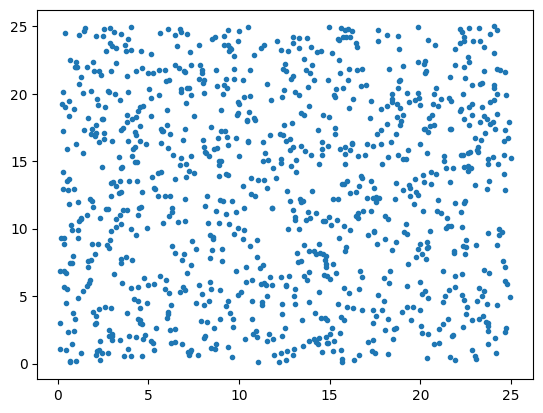

In [6]:
dim = 25

num_points=1000
np.random.seed(42)
coords_x=np.random.uniform(low=0, high=dim, size=num_points)
coords_y=np.random.uniform(low=0, high=dim, size=num_points)

plt.plot(coords_x, coords_y, ".")

plt.show()

In [8]:
# # start with a super simple case:
#     * linear separation
#     * then increase to non-linear separation (e.g circular or letter shape)
     
# At the end, test hvor sentitivt nettverket er til sparce data. Spesielt under trening. Vil forvente at den er bedre når dataen er tett fordi da er det let å finne et mønster i treningen som også finnes i test data. Med sparse data er det mer utfordrende.

### Circle dataset

Shape of synthetic dataset (X, y): (torch.Size([1000, 2]), torch.Size([1000]))


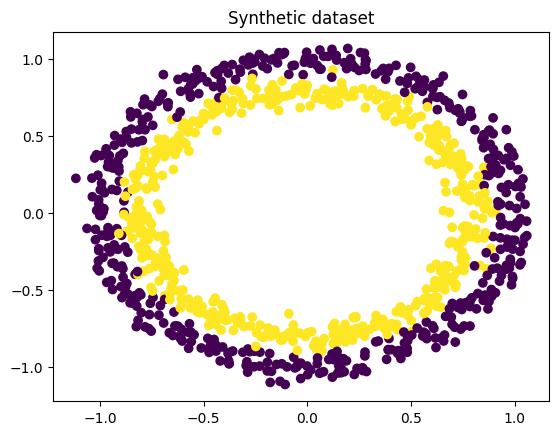

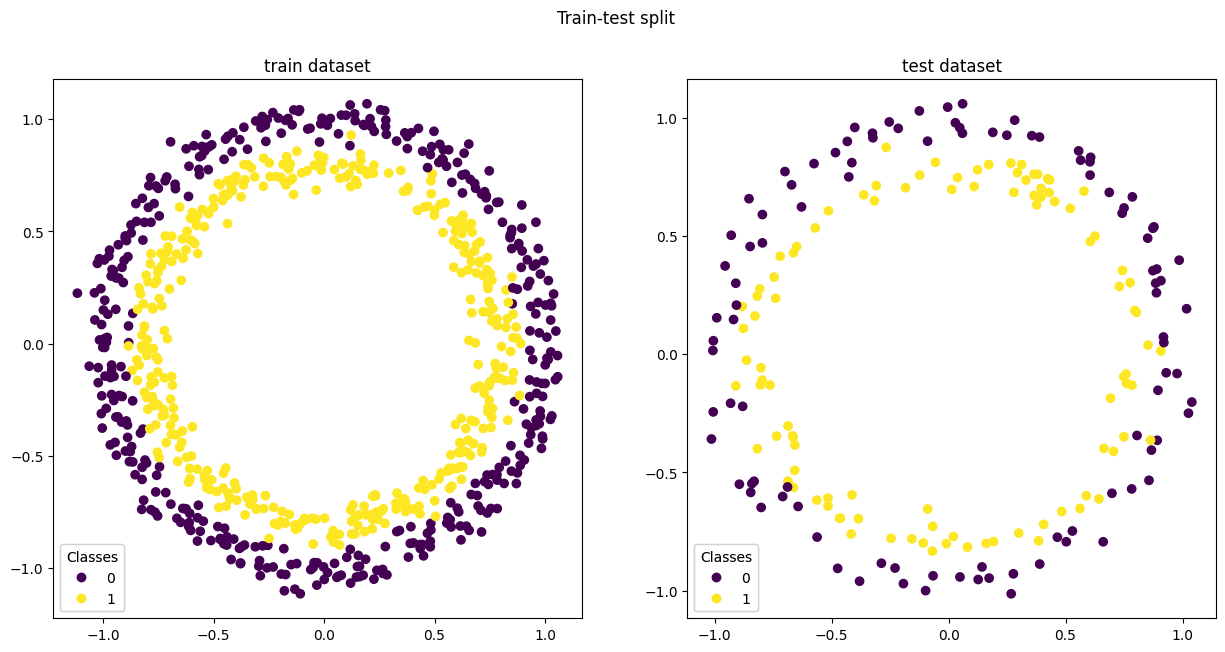

In [58]:
# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, # Make a large circle containing a smaller circle in 2d
                    noise=0.05, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

train_dataloader, test_dataloader, train_data, test_data, X_train, y_train, X_test, y_test = get_dataloader_from_numpy_dataset(X, y)

# Get dim
input_dim = X.shape[-1] # image_dim # 
if len(y.shape) == 1:
    output_dim = 1
else:
    output_dim = y.shape[-1] # len(class_names) #

### Train and evaluate model

In [51]:
activation_functions = [
    nn.ReLU,
    nn.Sigmoid,
    nn.SiLU,
    nn.Tanh,
    nn.ELU,
    nn.Hardsigmoid,
    nn.GELU,
]


Activation function ReLU:

----> EPOCH 0 of 100:
Train loss: 0.69799 | Train accuracy: 48.00%
Test loss: 47.00000 | Test accuracy: 53.00%

----> EPOCH 1 of 100:
Train loss: 0.69684 | Train accuracy: 48.25%
Test loss: 50.00000 | Test accuracy: 50.00%

----> EPOCH 2 of 100:
Train loss: 0.69552 | Train accuracy: 50.25%
Test loss: 48.50000 | Test accuracy: 51.50%

----> EPOCH 3 of 100:
Train loss: 0.69301 | Train accuracy: 48.38%
Test loss: 45.50000 | Test accuracy: 54.50%

----> EPOCH 4 of 100:
Train loss: 0.68891 | Train accuracy: 54.62%
Test loss: 48.50000 | Test accuracy: 51.50%

----> EPOCH 5 of 100:
Train loss: 0.68982 | Train accuracy: 51.75%
Test loss: 51.50000 | Test accuracy: 48.50%

----> EPOCH 6 of 100:
Train loss: 0.68763 | Train accuracy: 54.50%
Test loss: 47.00000 | Test accuracy: 53.00%

----> EPOCH 7 of 100:
Train loss: 0.68301 | Train accuracy: 53.88%
Test loss: 36.00000 | Test accuracy: 64.00%

----> EPOCH 8 of 100:
Train loss: 0.67628 | Train accuracy: 57.88%
Test loss

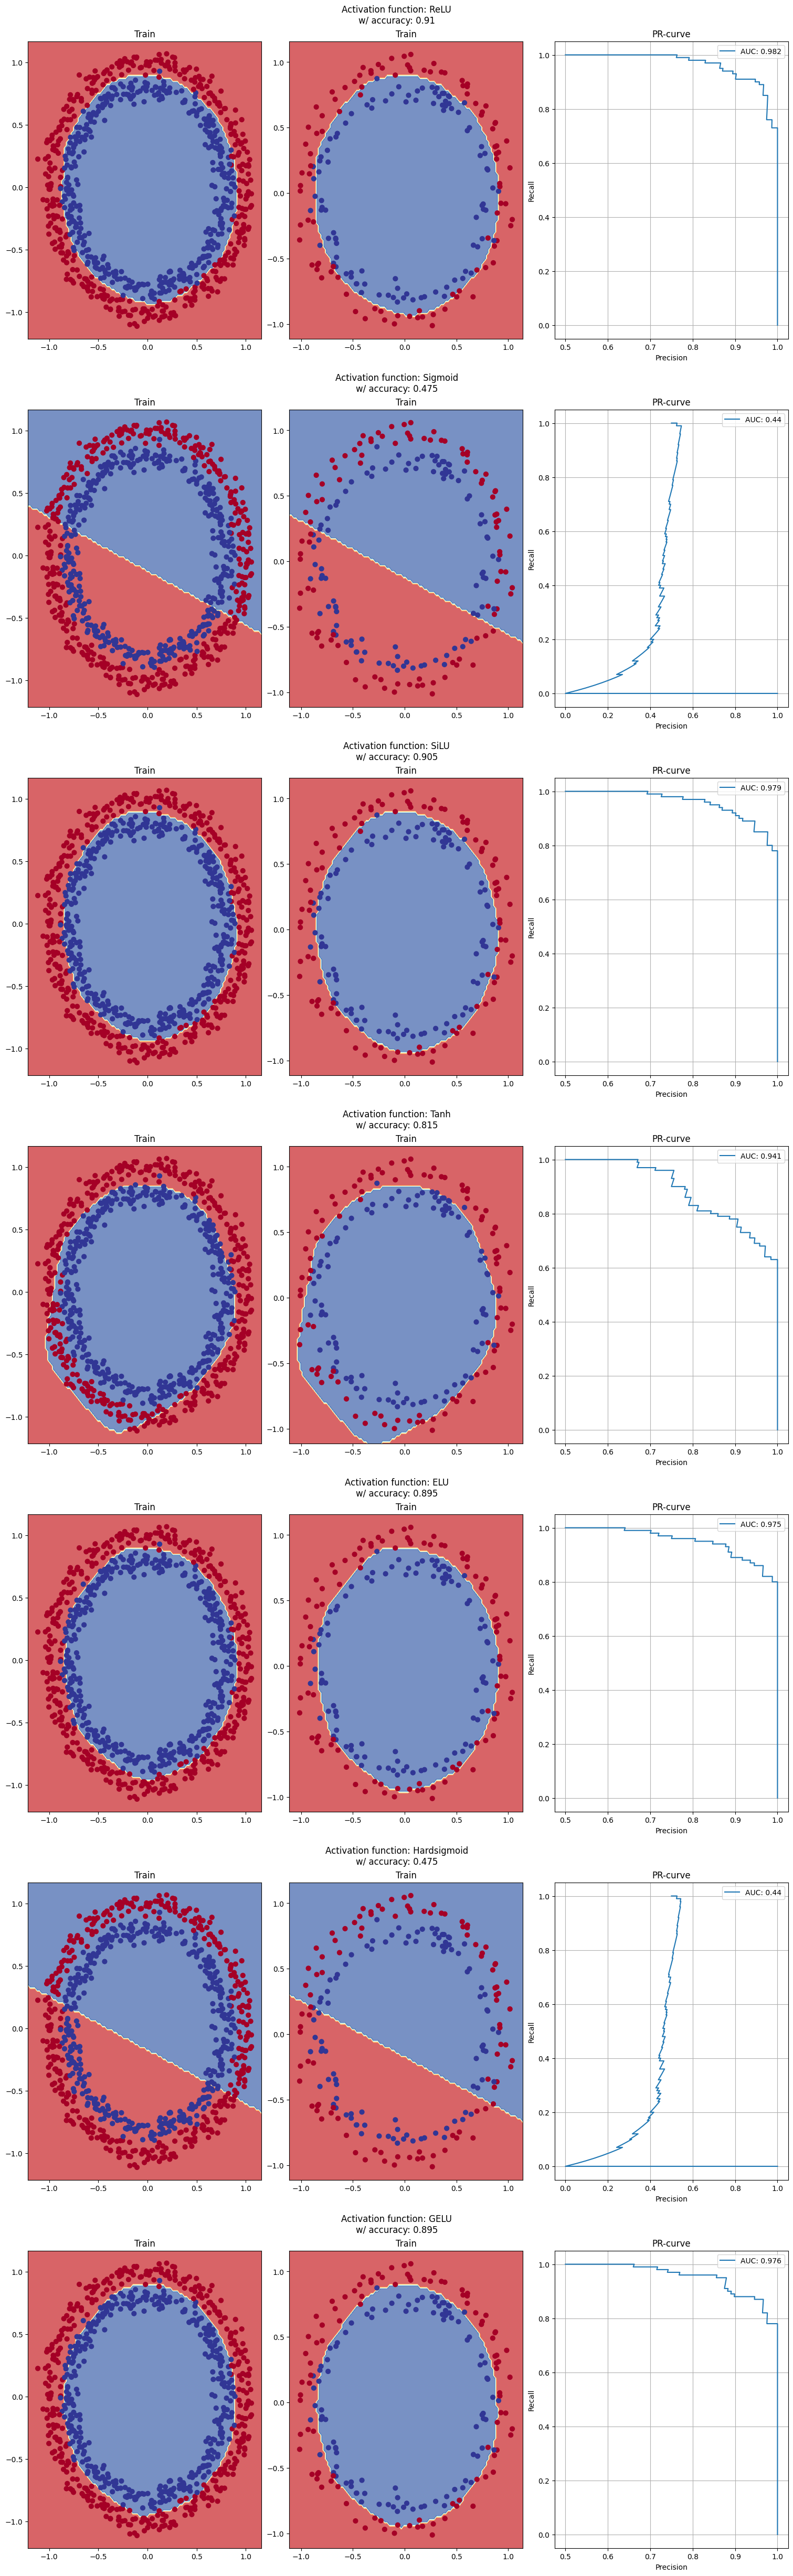

In [52]:
# Initialize plot for evaluation
fig = plt.figure(constrained_layout=True, figsize=(15, 7*len(activation_functions)))
axs = fig.subfigures(len(activation_functions), 1)

for a, activation_function in enumerate(activation_functions):
    print(f"\nActivation function {activation_function.__name__}:\n")
    
    # Create 1x3 subplots on each row
    subaxs = axs[a].subplots(1, 3)       
    
    # Initialize model
    torch.manual_seed(42) # set seed for random parameters in model
    euler_model = EulerNet(
        input_shape=input_dim,
        output_shape=output_dim,
        hidden_units=10,
        num_hidden_layers=10,
        activation_function=activation_function,
        )

    # Select optimizer and loss function
    loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in. Require inputs to have gone through the sigmoid activation function prior

    # Create an optimizer
    optimizer = torch.optim.SGD(
        params=euler_model.parameters(), 
        lr=0.1
    )

    # Train and test for multiple epochs
    epochs = 100
    for epoch in range(epochs):
        print(f"----> EPOCH {epoch} of {epochs}:")
        train_model(
            model=euler_model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            verbose=False
        )
        test_model(
            model=euler_model,
            data_loader=test_dataloader,
            loss_fn=loss_fn
        )

    # Plot decision boundaries for training and test sets
    for i, data in enumerate(zip([X_train.numpy(), X_test.numpy()], [y_train.numpy(), y_test.numpy()])):
        X_data, y_data = data
        xx, yy, y_grid_pred = decision_boundary_grid(
            model=euler_model,
            X=X_data,
            y=y_data
            )
        subaxs[i].contourf(xx, yy, y_grid_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
        subaxs[i].scatter(X_data[:, 0], X_data[:, 1], c=y_data, s=40, cmap=plt.cm.RdYlBu)
        subaxs[i].set_xlim(xx.min(), xx.max())
        subaxs[i].set_ylim(yy.min(), yy.max())
        subaxs[i].set_title("Train")

    # Metrics
    probs = euler_model(X_test)
    preds = torch.round(probs)
    target = y_test.type(torch.int)
    acc_metric = BinaryAccuracy()
    prc_metric = BinaryPrecisionRecallCurve()

    bprc = prc_metric(probs, target) # Precision, recall, threshold
    subaxs[2].plot(bprc[0], bprc[1], label=f"AUC: {np.round(auc(bprc[1], bprc[0]), 3)}") # auc(recall, precision)
    subaxs[2].grid()
    subaxs[2].set_xlabel("Precision")
    subaxs[2].set_ylabel("Recall")
    subaxs[2].legend()
    subaxs[2].set_title("PR-curve")

    axs[a].suptitle(
        f"Activation function: {activation_function.__name__}\n"
        f"w/ accuracy: {np.round(acc_metric(preds, target).item(), 3)}") 

    # Test metrics 
    test_metrics = test_model(
            model=euler_model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            evaluate=True # get final result(evaluate=True)
        )
    print(f"Test metrics: {test_metrics}")
    
plt.show()

In [ ]:
# Random sample from test dataset
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# Make predictions on test samples with model 2
pred_probs= make_predictions(model=euler_model, 
                            data=test_samples)

# View probabilities, prediction, target label
print(f"probs: \n{pred_probs}")
print(f"pred: \n{torch.round(pred_probs)}")
print(f"test traget labels: \n{test_labels}")

acc: 0.9350000023841858


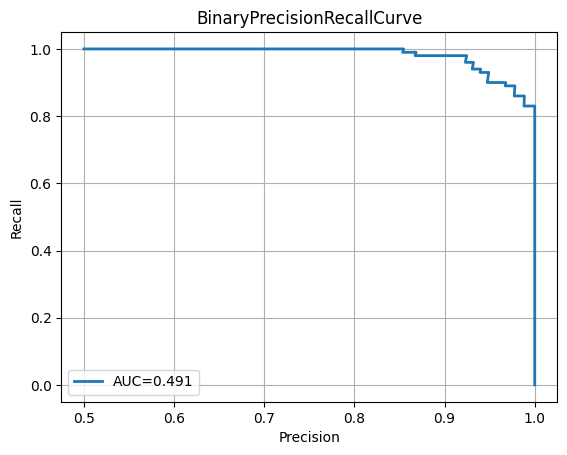

In [470]:
# Metrics
probs = euler_model(X_test)
preds = torch.round(probs)
target = y_test.type(torch.int)


metric = BinaryAccuracy()
print(f"acc: {metric(preds, target)}")

# bprc = BinaryPrecisionRecallCurve(thresholds=None)
# b = bprc(probs, target)
# plt.plot(b[0], b[1])
# plt.show()

# bprc = BinaryPrecisionRecallCurve(thresholds=5)
# b = bprc(probs, target)
# plt.plot(b[0], b[1])
# plt.show()

metric = BinaryPrecisionRecallCurve()
metric.update(probs, target)
fig_, ax_ = metric.plot(score=True)